In [10]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.python.keras._impl.keras.layers import Input
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.python.keras.layers import (Activation, Conv2D, Dense, Dropout, Flatten,
                                            MaxPool2D)
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import datetime

In [11]:
BATCH_SIZE = 256
EPOCHS = 27
PATIENCE = 50
LEARNING_RATE = 0.001
now = str(datetime.datetime.now())
CHECKPOINT_NAME = '_'.join(('checkpoint ' + now).split(' '))
print(CHECKPOINT_NAME)


Read data and add it to a csv

In [12]:
def load_data(test=False, mode=0, rgb=False):
    files = ['fer2013/training.csv',
             'fer2013/publictest.csv',
             'fer2013/privatetest.csv']
    
    data = pd.read_csv(files[mode])
    
    data['pixels'] = data['pixels'].apply(lambda img: np.fromstring(img, sep=' '))
    X = np.vstack(data['pixels'].values)
    # #normalize data
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    if rgb: # transform data cu rgb if needed
        X = cv2.cvtColor(data['pixels'], cv2.COLOR_GRAY2RGB)
        X = X.reshape(-1, 48, 48, 3)
    else:
        X = X.reshape(-1, 48, 48, 1)

    print(X.shape)
    
    if not test:
        y = data['emotion'].values
        y = y.astype(np.int)
        y = to_categorical(y)
    else:
        y = None

    return X, y


In [13]:
checkpointer = ModelCheckpoint(filepath='checkpoints/{0}.h5'.format(CHECKPOINT_NAME), verbose=0, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=0, mode='auto')
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=BATCH_SIZE, write_images=True)

model_callbacks = [checkpointer, early_stop, tensorboard]

In [14]:
model = Sequential()
model.add(Conv2D(64, 3, input_shape=(48, 48, 1), activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7))
model.add(Activation('softmax'))

model.summary()

optimizer = Adam(lr=0.01)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 19, 19, 32)        18464     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 17, 17, 32)        9248      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 32)        9248      
__________

In [15]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             rotation_range=20,
                             featurewise_center=True,
                             featurewise_std_normalization=True)

In [16]:
X,y = load_data(mode=0)
datagen.fit(X)
X_validation, y_validation = load_data(mode=1)

hist = model.fit_generator(datagen.flow(X, y, batch_size=BATCH_SIZE), shuffle=True, epochs=EPOCHS,
                           callbacks=model_callbacks, verbose=1,
                           validation_data=(X_validation, y_validation))

(28709, 48, 48, 1)


(3589, 48, 48, 1)


Epoch 1/27


  1/113 [..............................]  1/113 [..............................] - ETA: 6:21 - loss: 1.9489 - acc: 0.1523

  2/113 [..............................]  2/113 [..............................] - ETA: 3:31 - loss: 2.3005 - acc: 0.1602

  3/113 [..............................]  3/113 [..............................] - ETA: 2:34 - loss: 2.1765 - acc: 0.1615

  4/113 [>.............................]  4/113 [>.............................] - ETA: 2:06 - loss: 2.1357 - acc: 0.1562

  5/113 [>.............................]  5/113 [>.............................] - ETA: 1:48 - loss: 2.0936 - acc: 0.1570

  6/113 [>.............................]  6/113 [>.............................] - ETA: 1:37 - loss: 2.0657 - acc: 0.1569

  7/113 [>.............................]  7/113 [>.............................] - ETA: 1:29 - loss: 2.0413 - acc: 0.1499

  8/113 [=>............................]  8/113 [=>............................] - ETA: 1:22 - loss: 2.0222 - acc: 0.1561

  9/113 [=>............................]  9/113 [=>............................] - ETA: 1:17 - loss: 2.0127 - acc: 0.1539

 10/113 [=>............................] 10/113 [=>............................] - ETA: 1:13 - loss: 2.0000 - acc: 0.1577

 11/113 [=>............................] 11/113 [=>............................] - ETA: 1:09 - loss: 1.9887 - acc: 0.1618

 12/113 [==>...........................] 12/113 [==>...........................] - ETA: 1:06 - loss: 1.9790 - acc: 0.1685

 13/113 [==>...........................] 13/113 [==>...........................] - ETA: 1:03 - loss: 1.9716 - acc: 0.1703

 14/113 [==>...........................] 14/113 [==>...........................] - ETA: 1:01 - loss: 1.9651 - acc: 0.1721

 15/113 [==>...........................] 15/113 [==>...........................] - ETA: 59s - loss: 1.9575 - acc: 0.1783 

 16/113 [===>..........................] 16/113 [===>..........................] - ETA: 57s - loss: 1.9522 - acc: 0.1801

 17/113 [===>..........................] 17/113 [===>..........................] - ETA: 55s - loss: 1.9461 - acc: 0.1817

 18/113 [===>..........................] 18/113 [===>..........................] - ETA: 54s - loss: 1.9421 - acc: 0.1846

 19/113 [====>.........................] 19/113 [====>.........................] - ETA: 52s - loss: 1.9378 - acc: 0.1850

 20/113 [====>.........................] 20/113 [====>.........................] - ETA: 51s - loss: 1.9353 - acc: 0.1849

 21/113 [====>.........................] 21/113 [====>.........................] - ETA: 50s - loss: 1.9298 - acc: 0.1860

 22/113 [====>.........................] 22/113 [====>.........................] - ETA: 48s - loss: 1.9241 - acc: 0.1903

 23/113 [=====>........................] 23/113 [=====>........................] - ETA: 47s - loss: 1.9198 - acc: 0.1925

 24/113 [=====>........................] 24/113 [=====>........................] - ETA: 46s - loss: 1.9174 - acc: 0.1936

 25/113 [=====>........................] 25/113 [=====>........................] - ETA: 45s - loss: 1.9143 - acc: 0.1949

 26/113 [=====>........................] 26/113 [=====>........................] - ETA: 44s - loss: 1.9105 - acc: 0.1972

 27/113 [======>.......................] 27/113 [======>.......................] - ETA: 43s - loss: 1.9071 - acc: 0.1986

 28/113 [======>.......................] 28/113 [======>.......................] - ETA: 42s - loss: 1.9058 - acc: 0.1983

 29/113 [======>.......................] 29/113 [======>.......................] - ETA: 42s - loss: 1.9037 - acc: 0.2008

 30/113 [======>.......................] 30/113 [======>.......................] - ETA: 41s - loss: 1.9002 - acc: 0.2018

 31/113 [=======>......................] 31/113 [=======>......................] - ETA: 40s - loss: 1.8974 - acc: 0.2028

 32/113 [=======>......................] 32/113 [=======>......................] - ETA: 39s - loss: 1.8956 - acc: 0.2028

 33/113 [=======>......................] 33/113 [=======>......................] - ETA: 39s - loss: 1.8940 - acc: 0.2039

 34/113 [========>.....................] 34/113 [========>.....................] - ETA: 38s - loss: 1.8917 - acc: 0.2048

 35/113 [========>.....................] 35/113 [========>.....................] - ETA: 37s - loss: 1.8902 - acc: 0.2058

 36/113 [========>.....................] 36/113 [========>.....................] - ETA: 37s - loss: 1.8883 - acc: 0.2069

 37/113 [========>.....................] 37/113 [========>.....................] - ETA: 36s - loss: 1.8863 - acc: 0.2074

 38/113 [=========>....................] 38/113 [=========>....................] - ETA: 35s - loss: 1.8845 - acc: 0.2092

 39/113 [=========>....................] 39/113 [=========>....................] - ETA: 35s - loss: 1.8831 - acc: 0.2108

 40/113 [=========>....................] 40/113 [=========>....................] - ETA: 34s - loss: 1.8814 - acc: 0.2122

 41/113 [=========>....................] 41/113 [=========>....................] - ETA: 33s - loss: 1.8801 - acc: 0.2120

 42/113 [==========>...................] 42/113 [==========>...................] - ETA: 33s - loss: 1.8793 - acc: 0.2130

 43/113 [==========>...................] 43/113 [==========>...................] - ETA: 32s - loss: 1.8779 - acc: 0.2144

 44/113 [==========>...................] 44/113 [==========>...................] - ETA: 32s - loss: 1.8760 - acc: 0.2161

 45/113 [==========>...................] 45/113 [==========>...................] - ETA: 31s - loss: 1.8743 - acc: 0.2176

 46/113 [===========>..................] 46/113 [===========>..................] - ETA: 31s - loss: 1.8736 - acc: 0.2174

 47/113 [===========>..................] 47/113 [===========>..................] - ETA: 30s - loss: 1.8727 - acc: 0.2178

 48/113 [===========>..................] 48/113 [===========>..................] - ETA: 29s - loss: 1.8717 - acc: 0.2194

 49/113 [============>.................] 49/113 [============>.................] - ETA: 29s - loss: 1.8710 - acc: 0.2190

 50/113 [============>.................] 50/113 [============>.................] - ETA: 28s - loss: 1.8694 - acc: 0.2199

 51/113 [============>.................] 51/113 [============>.................] - ETA: 28s - loss: 1.8683 - acc: 0.2204

 52/113 [============>.................] 52/113 [============>.................] - ETA: 27s - loss: 1.8663 - acc: 0.2217

 53/113 [=============>................] 53/113 [=============>................] - ETA: 27s - loss: 1.8651 - acc: 0.2222

 54/113 [=============>................] 54/113 [=============>................] - ETA: 26s - loss: 1.8640 - acc: 0.2228

 55/113 [=============>................] 55/113 [=============>................] - ETA: 26s - loss: 1.8627 - acc: 0.2246

 56/113 [=============>................] 56/113 [=============>................] - ETA: 25s - loss: 1.8612 - acc: 0.2257

 57/113 [==============>...............] 57/113 [==============>...............] - ETA: 25s - loss: 1.8599 - acc: 0.2261

 58/113 [==============>...............] 58/113 [==============>...............] - ETA: 24s - loss: 1.8588 - acc: 0.2267

 59/113 [==============>...............] 59/113 [==============>...............] - ETA: 24s - loss: 1.8584 - acc: 0.2272

 60/113 [==============>...............] 60/113 [==============>...............] - ETA: 23s - loss: 1.8576 - acc: 0.2275

 61/113 [===============>..............] 61/113 [===============>..............] - ETA: 23s - loss: 1.8575 - acc: 0.2275

 62/113 [===============>..............] 62/113 [===============>..............] - ETA: 22s - loss: 1.8566 - acc: 0.2282

 63/113 [===============>..............] 63/113 [===============>..............] - ETA: 22s - loss: 1.8563 - acc: 0.2278

 64/113 [===============>..............] 64/113 [===============>..............] - ETA: 21s - loss: 1.8559 - acc: 0.2271

 65/113 [================>.............] 65/113 [================>.............] - ETA: 21s - loss: 1.8549 - acc: 0.2276

 66/113 [================>.............] 66/113 [================>.............] - ETA: 20s - loss: 1.8540 - acc: 0.2285

 67/113 [================>.............] 67/113 [================>.............] - ETA: 20s - loss: 1.8527 - acc: 0.2293

 68/113 [=================>............] 68/113 [=================>............] - ETA: 19s - loss: 1.8518 - acc: 0.2302

 69/113 [=================>............] 69/113 [=================>............] - ETA: 19s - loss: 1.8520 - acc: 0.2303

 70/113 [=================>............] 70/113 [=================>............] - ETA: 19s - loss: 1.8514 - acc: 0.2303

 71/113 [=================>............] 71/113 [=================>............] - ETA: 18s - loss: 1.8512 - acc: 0.2301

 72/113 [==================>...........] 72/113 [==================>...........] - ETA: 18s - loss: 1.8513 - acc: 0.2295

 73/113 [==================>...........] 73/113 [==================>...........] - ETA: 17s - loss: 1.8507 - acc: 0.2305

 74/113 [==================>...........] 74/113 [==================>...........] - ETA: 17s - loss: 1.8505 - acc: 0.2304

 75/113 [==================>...........] 75/113 [==================>...........] - ETA: 16s - loss: 1.8502 - acc: 0.2306

 76/113 [===================>..........] 76/113 [===================>..........] - ETA: 16s - loss: 1.8497 - acc: 0.2310

 77/113 [===================>..........] 77/113 [===================>..........] - ETA: 15s - loss: 1.8491 - acc: 0.2313

 78/113 [===================>..........] 78/113 [===================>..........] - ETA: 15s - loss: 1.8485 - acc: 0.2315

 79/113 [===================>..........] 79/113 [===================>..........] - ETA: 14s - loss: 1.8477 - acc: 0.2320

 80/113 [====================>.........] 80/113 [====================>.........] - ETA: 14s - loss: 1.8475 - acc: 0.2318

 81/113 [====================>.........] 81/113 [====================>.........] - ETA: 14s - loss: 1.8472 - acc: 0.2318

 82/113 [====================>.........] 82/113 [====================>.........] - ETA: 13s - loss: 1.8464 - acc: 0.2325

 83/113 [=====================>........] 83/113 [=====================>........] - ETA: 13s - loss: 1.8462 - acc: 0.2322

 84/113 [=====================>........] 84/113 [=====================>........] - ETA: 12s - loss: 1.8456 - acc: 0.2321

 85/113 [=====================>........] 85/113 [=====================>........] - ETA: 12s - loss: 1.8450 - acc: 0.2325

 86/113 [=====================>........] 86/113 [=====================>........] - ETA: 11s - loss: 1.8450 - acc: 0.2325

 87/113 [======================>.......] 87/113 [======================>.......] - ETA: 11s - loss: 1.8446 - acc: 0.2331

 88/113 [======================>.......] 88/113 [======================>.......] - ETA: 10s - loss: 1.8441 - acc: 0.2334

 89/113 [======================>.......] 89/113 [======================>.......] - ETA: 10s - loss: 1.8438 - acc: 0.2334

 90/113 [======================>.......] 90/113 [======================>.......] - ETA: 10s - loss: 1.8440 - acc: 0.2330

 91/113 [=======================>......] 91/113 [=======================>......] - ETA: 9s - loss: 1.8436 - acc: 0.2333 

 92/113 [=======================>......] 92/113 [=======================>......] - ETA: 9s - loss: 1.8430 - acc: 0.2340

 93/113 [=======================>......] 93/113 [=======================>......] - ETA: 8s - loss: 1.8425 - acc: 0.2342

 94/113 [=======================>......] 94/113 [=======================>......] - ETA: 8s - loss: 1.8424 - acc: 0.2347

 95/113 [========================>.....] 95/113 [========================>.....] - ETA: 7s - loss: 1.8424 - acc: 0.2351

 96/113 [========================>.....] 96/113 [========================>.....] - ETA: 7s - loss: 1.8420 - acc: 0.2353

 97/113 [========================>.....] 97/113 [========================>.....] - ETA: 6s - loss: 1.8417 - acc: 0.2358

 98/113 [=========================>....] 98/113 [=========================>....] - ETA: 6s - loss: 1.8418 - acc: 0.2357

 99/113 [=========================>....] 99/113 [=========================>....] - ETA: 6s - loss: 1.8411 - acc: 0.2361

100/113 [=========================>....]100/113 [=========================>....] - ETA: 5s - loss: 1.8412 - acc: 0.2362

101/113 [=========================>....]101/113 [=========================>....] - ETA: 5s - loss: 1.8411 - acc: 0.2366

102/113 [==========================>...]102/113 [==========================>...] - ETA: 4s - loss: 1.8410 - acc: 0.2368

103/113 [==========================>...]103/113 [==========================>...] - ETA: 4s - loss: 1.8408 - acc: 0.2369

104/113 [==========================>...]104/113 [==========================>...] - ETA: 3s - loss: 1.8404 - acc: 0.2372

105/113 [==========================>...]105/113 [==========================>...] - ETA: 3s - loss: 1.8402 - acc: 0.2375

106/113 [===========================>..]106/113 [===========================>..] - ETA: 3s - loss: 1.8398 - acc: 0.2379

107/113 [===========================>..]107/113 [===========================>..] - ETA: 2s - loss: 1.8397 - acc: 0.2380

108/113 [===========================>..]108/113 [===========================>..] - ETA: 2s - loss: 1.8397 - acc: 0.2379

109/113 [===========================>..]109/113 [===========================>..] - ETA: 1s - loss: 1.8396 - acc: 0.2377

110/113 [============================>.]110/113 [============================>.] - ETA: 1s - loss: 1.8391 - acc: 0.2382

111/113 [============================>.]111/113 [============================>.] - ETA: 0s - loss: 1.8390 - acc: 0.2382

112/113 [============================>.]112/113 [============================>.] - ETA: 0s - loss: 1.8386 - acc: 0.2385

113/113 [==============================]113/113 [==============================] - 51s 448ms/step - loss: 1.8383 - acc: 0.2388 - val_loss: 1.8139 - val_acc: 0.2494



Epoch 2/27


  1/113 [..............................]  1/113 [..............................] - ETA: 44s - loss: 1.8326 - acc: 0.2578

  2/113 [..............................]  2/113 [..............................] - ETA: 43s - loss: 1.8377 - acc: 0.2441

  3/113 [..............................]  3/113 [..............................] - ETA: 42s - loss: 1.8385 - acc: 0.2370

  4/113 [>.............................]  4/113 [>.............................] - ETA: 43s - loss: 1.8296 - acc: 0.2461

  5/113 [>.............................]  5/113 [>.............................] - ETA: 43s - loss: 1.8217 - acc: 0.2547

  6/113 [>.............................]  6/113 [>.............................] - ETA: 42s - loss: 1.8248 - acc: 0.2559

  7/113 [>.............................]  7/113 [>.............................] - ETA: 42s - loss: 1.8211 - acc: 0.2545

  8/113 [=>............................]  8/113 [=>............................] - ETA: 42s - loss: 1.8241 - acc: 0.2529

  9/113 [=>............................]  9/113 [=>............................] - ETA: 41s - loss: 1.8188 - acc: 0.2548

 10/113 [=>............................] 10/113 [=>............................] - ETA: 41s - loss: 1.8151 - acc: 0.2574

 11/113 [=>............................] 11/113 [=>............................] - ETA: 40s - loss: 1.8174 - acc: 0.2557

 12/113 [==>...........................] 12/113 [==>...........................] - ETA: 40s - loss: 1.8158 - acc: 0.2552

 13/113 [==>...........................] 13/113 [==>...........................] - ETA: 39s - loss: 1.8146 - acc: 0.2575

 14/113 [==>...........................] 14/113 [==>...........................] - ETA: 39s - loss: 1.8153 - acc: 0.2567

 15/113 [==>...........................] 15/113 [==>...........................] - ETA: 39s - loss: 1.8153 - acc: 0.2544

 16/113 [===>..........................] 16/113 [===>..........................] - ETA: 38s - loss: 1.8136 - acc: 0.2556

 17/113 [===>..........................] 17/113 [===>..........................] - ETA: 36s - loss: 1.8203 - acc: 0.2485

 18/113 [===>..........................] 18/113 [===>..........................] - ETA: 36s - loss: 1.8179 - acc: 0.2508

 19/113 [====>.........................] 19/113 [====>.........................] - ETA: 36s - loss: 1.8196 - acc: 0.2495

 20/113 [====>.........................] 20/113 [====>.........................] - ETA: 35s - loss: 1.8178 - acc: 0.2507

 21/113 [====>.........................] 21/113 [====>.........................] - ETA: 35s - loss: 1.8184 - acc: 0.2483

 22/113 [====>.........................] 22/113 [====>.........................] - ETA: 35s - loss: 1.8185 - acc: 0.2494

 23/113 [=====>........................] 23/113 [=====>........................] - ETA: 34s - loss: 1.8180 - acc: 0.2506

 24/113 [=====>........................] 24/113 [=====>........................] - ETA: 34s - loss: 1.8201 - acc: 0.2503

 25/113 [=====>........................] 25/113 [=====>........................] - ETA: 34s - loss: 1.8177 - acc: 0.2515

 26/113 [=====>........................] 26/113 [=====>........................] - ETA: 33s - loss: 1.8178 - acc: 0.2502

 27/113 [======>.......................] 27/113 [======>.......................] - ETA: 33s - loss: 1.8162 - acc: 0.2517

 28/113 [======>.......................] 28/113 [======>.......................] - ETA: 32s - loss: 1.8156 - acc: 0.2522

 29/113 [======>.......................] 29/113 [======>.......................] - ETA: 32s - loss: 1.8166 - acc: 0.2516

 30/113 [======>.......................] 30/113 [======>.......................] - ETA: 32s - loss: 1.8177 - acc: 0.2516

 31/113 [=======>......................] 31/113 [=======>......................] - ETA: 31s - loss: 1.8173 - acc: 0.2520

 32/113 [=======>......................] 32/113 [=======>......................] - ETA: 31s - loss: 1.8173 - acc: 0.2513

 33/113 [=======>......................] 33/113 [=======>......................] - ETA: 31s - loss: 1.8169 - acc: 0.2515

 34/113 [========>.....................] 34/113 [========>.....................] - ETA: 30s - loss: 1.8163 - acc: 0.2520

 35/113 [========>.....................] 35/113 [========>.....................] - ETA: 30s - loss: 1.8160 - acc: 0.2531

 36/113 [========>.....................] 36/113 [========>.....................] - ETA: 30s - loss: 1.8164 - acc: 0.2516

 37/113 [========>.....................] 37/113 [========>.....................] - ETA: 29s - loss: 1.8171 - acc: 0.2510

 38/113 [=========>....................] 38/113 [=========>....................] - ETA: 29s - loss: 1.8171 - acc: 0.2502

 39/113 [=========>....................] 39/113 [=========>....................] - ETA: 29s - loss: 1.8168 - acc: 0.2493

 40/113 [=========>....................] 40/113 [=========>....................] - ETA: 28s - loss: 1.8183 - acc: 0.2493

 41/113 [=========>....................] 41/113 [=========>....................] - ETA: 28s - loss: 1.8186 - acc: 0.2498

 42/113 [==========>...................] 42/113 [==========>...................] - ETA: 28s - loss: 1.8197 - acc: 0.2489

 43/113 [==========>...................] 43/113 [==========>...................] - ETA: 27s - loss: 1.8196 - acc: 0.2489

 44/113 [==========>...................] 44/113 [==========>...................] - ETA: 27s - loss: 1.8198 - acc: 0.2484

 45/113 [==========>...................] 45/113 [==========>...................] - ETA: 26s - loss: 1.8190 - acc: 0.2486

 46/113 [===========>..................] 46/113 [===========>..................] - ETA: 26s - loss: 1.8190 - acc: 0.2489

 47/113 [===========>..................] 47/113 [===========>..................] - ETA: 26s - loss: 1.8182 - acc: 0.2492

 48/113 [===========>..................] 48/113 [===========>..................] - ETA: 25s - loss: 1.8179 - acc: 0.2492

 49/113 [============>.................] 49/113 [============>.................] - ETA: 25s - loss: 1.8174 - acc: 0.2493

 50/113 [============>.................] 50/113 [============>.................] - ETA: 25s - loss: 1.8182 - acc: 0.2490

 51/113 [============>.................] 51/113 [============>.................] - ETA: 24s - loss: 1.8179 - acc: 0.2490

 52/113 [============>.................] 52/113 [============>.................] - ETA: 24s - loss: 1.8185 - acc: 0.2483

 53/113 [=============>................] 53/113 [=============>................] - ETA: 24s - loss: 1.8177 - acc: 0.2484

 54/113 [=============>................] 54/113 [=============>................] - ETA: 23s - loss: 1.8182 - acc: 0.2483

 55/113 [=============>................] 55/113 [=============>................] - ETA: 23s - loss: 1.8177 - acc: 0.2484

 56/113 [=============>................] 56/113 [=============>................] - ETA: 22s - loss: 1.8175 - acc: 0.2479

 57/113 [==============>...............] 57/113 [==============>...............] - ETA: 22s - loss: 1.8168 - acc: 0.2485

 58/113 [==============>...............] 58/113 [==============>...............] - ETA: 22s - loss: 1.8171 - acc: 0.2487

 59/113 [==============>...............] 59/113 [==============>...............] - ETA: 21s - loss: 1.8177 - acc: 0.2481

 60/113 [==============>...............] 60/113 [==============>...............] - ETA: 21s - loss: 1.8173 - acc: 0.2484

 61/113 [===============>..............] 61/113 [===============>..............] - ETA: 20s - loss: 1.8170 - acc: 0.2485

 62/113 [===============>..............] 62/113 [===============>..............] - ETA: 20s - loss: 1.8171 - acc: 0.2482

 63/113 [===============>..............] 63/113 [===============>..............] - ETA: 20s - loss: 1.8179 - acc: 0.2474

 64/113 [===============>..............] 64/113 [===============>..............] - ETA: 19s - loss: 1.8180 - acc: 0.2480

 65/113 [================>.............] 65/113 [================>.............] - ETA: 19s - loss: 1.8180 - acc: 0.2485

 66/113 [================>.............] 66/113 [================>.............] - ETA: 18s - loss: 1.8180 - acc: 0.2480

 67/113 [================>.............] 67/113 [================>.............] - ETA: 18s - loss: 1.8178 - acc: 0.2482

 68/113 [=================>............] 68/113 [=================>............] - ETA: 18s - loss: 1.8177 - acc: 0.2480

 69/113 [=================>............] 69/113 [=================>............] - ETA: 17s - loss: 1.8182 - acc: 0.2479

 70/113 [=================>............] 70/113 [=================>............] - ETA: 17s - loss: 1.8179 - acc: 0.2479

 71/113 [=================>............] 71/113 [=================>............] - ETA: 16s - loss: 1.8180 - acc: 0.2483

 72/113 [==================>...........] 72/113 [==================>...........] - ETA: 16s - loss: 1.8185 - acc: 0.2474

 73/113 [==================>...........] 73/113 [==================>...........] - ETA: 16s - loss: 1.8183 - acc: 0.2475

 74/113 [==================>...........] 74/113 [==================>...........] - ETA: 15s - loss: 1.8183 - acc: 0.2476

 75/113 [==================>...........] 75/113 [==================>...........] - ETA: 15s - loss: 1.8183 - acc: 0.2473

 76/113 [===================>..........] 76/113 [===================>..........] - ETA: 14s - loss: 1.8182 - acc: 0.2476

 77/113 [===================>..........] 77/113 [===================>..........] - ETA: 14s - loss: 1.8178 - acc: 0.2480

 78/113 [===================>..........] 78/113 [===================>..........] - ETA: 13s - loss: 1.8175 - acc: 0.2483

 79/113 [===================>..........] 79/113 [===================>..........] - ETA: 13s - loss: 1.8173 - acc: 0.2482

 80/113 [====================>.........] 80/113 [====================>.........] - ETA: 13s - loss: 1.8175 - acc: 0.2485

 81/113 [====================>.........] 81/113 [====================>.........] - ETA: 12s - loss: 1.8173 - acc: 0.2484

 82/113 [====================>.........] 82/113 [====================>.........] - ETA: 12s - loss: 1.8169 - acc: 0.2490

 83/113 [=====================>........] 83/113 [=====================>........] - ETA: 11s - loss: 1.8167 - acc: 0.2492

 84/113 [=====================>........] 84/113 [=====================>........] - ETA: 11s - loss: 1.8169 - acc: 0.2495

 85/113 [=====================>........] 85/113 [=====================>........] - ETA: 11s - loss: 1.8166 - acc: 0.2496

 86/113 [=====================>........] 86/113 [=====================>........] - ETA: 10s - loss: 1.8165 - acc: 0.2493

 87/113 [======================>.......] 87/113 [======================>.......] - ETA: 10s - loss: 1.8168 - acc: 0.2493

 88/113 [======================>.......] 88/113 [======================>.......] - ETA: 9s - loss: 1.8164 - acc: 0.2495 

 89/113 [======================>.......] 89/113 [======================>.......] - ETA: 9s - loss: 1.8162 - acc: 0.2495

 90/113 [======================>.......] 90/113 [======================>.......] - ETA: 9s - loss: 1.8165 - acc: 0.2492

 91/113 [=======================>......] 91/113 [=======================>......] - ETA: 8s - loss: 1.8162 - acc: 0.2497

 92/113 [=======================>......] 92/113 [=======================>......] - ETA: 8s - loss: 1.8159 - acc: 0.2500

 93/113 [=======================>......] 93/113 [=======================>......] - ETA: 7s - loss: 1.8161 - acc: 0.2502

 94/113 [=======================>......] 94/113 [=======================>......] - ETA: 7s - loss: 1.8157 - acc: 0.2505

 95/113 [========================>.....] 95/113 [========================>.....] - ETA: 7s - loss: 1.8159 - acc: 0.2501

 96/113 [========================>.....] 96/113 [========================>.....] - ETA: 6s - loss: 1.8159 - acc: 0.2500

 97/113 [========================>.....] 97/113 [========================>.....] - ETA: 6s - loss: 1.8156 - acc: 0.2501

 98/113 [=========================>....] 98/113 [=========================>....] - ETA: 5s - loss: 1.8154 - acc: 0.2501

 99/113 [=========================>....] 99/113 [=========================>....] - ETA: 5s - loss: 1.8154 - acc: 0.2501

100/113 [=========================>....]100/113 [=========================>....] - ETA: 5s - loss: 1.8154 - acc: 0.2501

101/113 [=========================>....]101/113 [=========================>....] - ETA: 4s - loss: 1.8157 - acc: 0.2499

102/113 [==========================>...]102/113 [==========================>...] - ETA: 4s - loss: 1.8160 - acc: 0.2496

103/113 [==========================>...]103/113 [==========================>...] - ETA: 3s - loss: 1.8164 - acc: 0.2494

104/113 [==========================>...]104/113 [==========================>...] - ETA: 3s - loss: 1.8162 - acc: 0.2496

105/113 [==========================>...]105/113 [==========================>...] - ETA: 3s - loss: 1.8163 - acc: 0.2497

106/113 [===========================>..]106/113 [===========================>..] - ETA: 2s - loss: 1.8165 - acc: 0.2497

107/113 [===========================>..]107/113 [===========================>..] - ETA: 2s - loss: 1.8165 - acc: 0.2495

108/113 [===========================>..]108/113 [===========================>..] - ETA: 2s - loss: 1.8166 - acc: 0.2498

109/113 [===========================>..]109/113 [===========================>..] - ETA: 1s - loss: 1.8164 - acc: 0.2498

110/113 [============================>.]110/113 [============================>.] - ETA: 1s - loss: 1.8162 - acc: 0.2500

111/113 [============================>.]111/113 [============================>.] - ETA: 0s - loss: 1.8166 - acc: 0.2500

112/113 [============================>.]112/113 [============================>.] - ETA: 0s - loss: 1.8162 - acc: 0.2500

113/113 [==============================]113/113 [==============================] - 47s 417ms/step - loss: 1.8159 - acc: 0.2504 - val_loss: 1.8139 - val_acc: 0.2494



Epoch 3/27


  1/113 [..............................]  1/113 [..............................] - ETA: 45s - loss: 1.7959 - acc: 0.2305

  2/113 [..............................]  2/113 [..............................] - ETA: 44s - loss: 1.8124 - acc: 0.2480

  3/113 [..............................]  3/113 [..............................] - ETA: 45s - loss: 1.8066 - acc: 0.2474

  4/113 [>.............................]  4/113 [>.............................] - ETA: 45s - loss: 1.8057 - acc: 0.2617

  5/113 [>.............................]  5/113 [>.............................] - ETA: 44s - loss: 1.8083 - acc: 0.2531

  6/113 [>.............................]  6/113 [>.............................] - ETA: 43s - loss: 1.8030 - acc: 0.2520

  7/113 [>.............................]  7/113 [>.............................] - ETA: 42s - loss: 1.8045 - acc: 0.2550

  8/113 [=>............................]  8/113 [=>............................] - ETA: 42s - loss: 1.8035 - acc: 0.2559

  9/113 [=>............................]  9/113 [=>............................] - ETA: 42s - loss: 1.8030 - acc: 0.2552

 10/113 [=>............................] 10/113 [=>............................] - ETA: 41s - loss: 1.8055 - acc: 0.2543

 11/113 [=>............................] 11/113 [=>............................] - ETA: 41s - loss: 1.8032 - acc: 0.2557

 12/113 [==>...........................] 12/113 [==>...........................] - ETA: 41s - loss: 1.8038 - acc: 0.2565

 13/113 [==>...........................] 13/113 [==>...........................] - ETA: 40s - loss: 1.8021 - acc: 0.2560

 14/113 [==>...........................] 14/113 [==>...........................] - ETA: 40s - loss: 1.8035 - acc: 0.2545

 15/113 [==>...........................] 15/113 [==>...........................] - ETA: 40s - loss: 1.8021 - acc: 0.2555

 16/113 [===>..........................] 16/113 [===>..........................] - ETA: 39s - loss: 1.8020 - acc: 0.2568

 17/113 [===>..........................] 17/113 [===>..........................] - ETA: 39s - loss: 1.8054 - acc: 0.2546

 18/113 [===>..........................] 18/113 [===>..........................] - ETA: 38s - loss: 1.8050 - acc: 0.2543

 19/113 [====>.........................] 19/113 [====>.........................] - ETA: 38s - loss: 1.8064 - acc: 0.2551

 20/113 [====>.........................] 20/113 [====>.........................] - ETA: 37s - loss: 1.8078 - acc: 0.2541

 21/113 [====>.........................] 21/113 [====>.........................] - ETA: 37s - loss: 1.8071 - acc: 0.2530

 22/113 [====>.........................] 22/113 [====>.........................] - ETA: 36s - loss: 1.8087 - acc: 0.2514

 23/113 [=====>........................] 23/113 [=====>........................] - ETA: 36s - loss: 1.8075 - acc: 0.2529

 24/113 [=====>........................] 24/113 [=====>........................] - ETA: 35s - loss: 1.8077 - acc: 0.2521

 25/113 [=====>........................] 25/113 [=====>........................] - ETA: 35s - loss: 1.8084 - acc: 0.2512

 26/113 [=====>........................] 26/113 [=====>........................] - ETA: 35s - loss: 1.8080 - acc: 0.2511

 27/113 [======>.......................] 27/113 [======>.......................] - ETA: 34s - loss: 1.8085 - acc: 0.2513

 28/113 [======>.......................] 28/113 [======>.......................] - ETA: 33s - loss: 1.8075 - acc: 0.2491

 29/113 [======>.......................] 29/113 [======>.......................] - ETA: 32s - loss: 1.8088 - acc: 0.2484

 30/113 [======>.......................] 30/113 [======>.......................] - ETA: 32s - loss: 1.8101 - acc: 0.2488

KeyboardInterrupt: 

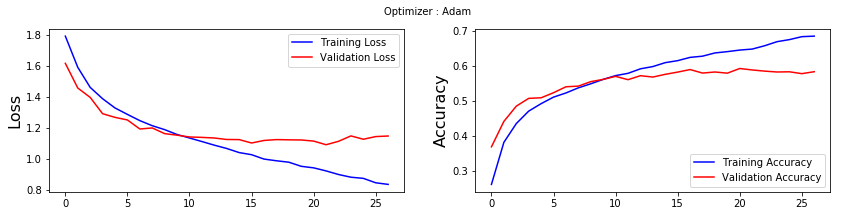

In [9]:
plt.figure(figsize=(14, 3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], 'b', label='Training Loss')
plt.plot(hist.history['val_loss'], 'r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], 'b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], 'r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [15]:
x_eval, y_eval = load_data(mode=2)

score = model.evaluate(x_eval, y_eval, verbose=1)
print('Score : ', score[0])
print('Accuracy : ', score[1] * 100)
model.save_weights('models/{0}.h5'.format(CHECKPOINT_NAME))

(3589, 48, 48, 1)
  32/3589 [..............................]  32/3589 [..............................] - ETA: 1s

 128/3589 [>.............................] 128/3589 [>.............................] - ETA: 1s

 224/3589 [>.............................] 224/3589 [>.............................] - ETA: 1s

 320/3589 [=>............................] 320/3589 [=>............................] - ETA: 1s

 416/3589 [==>...........................] 416/3589 [==>...........................] - ETA: 1s

 512/3589 [===>..........................] 512/3589 [===>..........................] - ETA: 1s

 608/3589 [====>.........................] 608/3589 [====>.........................] - ETA: 1s

 704/3589 [====>.........................] 704/3589 [====>.........................] - ETA: 1s

 800/3589 [=====>........................] 800/3589 [=====>........................] - ETA: 1s

 896/3589 [======>.......................] 896/3589 [======>.......................] - ETA: 1s

1024/3589 [=======>......................]1024/3589 [=======>......................] - ETA: 1s

1120/3589 [========>.....................]1120/3589 [========>.....................] - ETA: 1s

1216/3589 [=========>....................]1216/3589 [=========>....................] - ETA: 1s

1312/3589 [=========>....................]1312/3589 [=========>....................] - ETA: 1s

1408/3589 [==========>...................]1408/3589 [==========>...................] - ETA: 1s

1504/3589 [===========>..................]1504/3589 [===========>..................] - ETA: 1s

1600/3589 [============>.................]1600/3589 [============>.................] - ETA: 1s

1696/3589 [=============>................]1696/3589 [=============>................] - ETA: 1s

1792/3589 [=============>................]1792/3589 [=============>................] - ETA: 0s

1888/3589 [==============>...............]1888/3589 [==============>...............] - ETA: 0s

1984/3589 [===============>..............]1984/3589 [===============>..............] - ETA: 0s

2080/3589 [================>.............]2080/3589 [================>.............] - ETA: 0s

2176/3589 [=================>............]2176/3589 [=================>............] - ETA: 0s

2272/3589 [=================>............]2272/3589 [=================>............] - ETA: 0s

2368/3589 [==================>...........]2368/3589 [==================>...........] - ETA: 0s

2464/3589 [===================>..........]2464/3589 [===================>..........] - ETA: 0s

2560/3589 [====================>.........]2560/3589 [====================>.........] - ETA: 0s

2656/3589 [=====================>........]2656/3589 [=====================>........] - ETA: 0s

2752/3589 [======================>.......]2752/3589 [======================>.......] - ETA: 0s

2848/3589 [======================>.......]2848/3589 [======================>.......] - ETA: 0s

2944/3589 [=======================>......]2944/3589 [=======================>......] - ETA: 0s

3040/3589 [========================>.....]3040/3589 [========================>.....] - ETA: 0s

3136/3589 [=========================>....]3136/3589 [=========================>....] - ETA: 0s

3232/3589 [==========================>...]3232/3589 [==========================>...] - ETA: 0s

3328/3589 [==========================>...]3328/3589 [==========================>...] - ETA: 0s

3424/3589 [===========================>..]3424/3589 [===========================>..] - ETA: 0s

3520/3589 [============================>.]3520/3589 [============================>.] - ETA: 0s

3589/3589 [==============================]3589/3589 [==============================] - 2s 540us/step



Score :  1.0786776339054507
Accuracy :  59.40373363385927


In [17]:
x_eval, y_eval = load_data(mode=2)
model.load_weights('checkpoints/{0}.h5'.format(CHECKPOINT_NAME))

score = model.evaluate(x_eval, y_eval, verbose=1)
print('Score : ', score[0])
print('Accuracy : ', score[1] * 100)

(3589, 48, 48, 1)
  32/3589 [..............................]  32/3589 [..............................] - ETA: 1s

 128/3589 [>.............................] 128/3589 [>.............................] - ETA: 1s

 224/3589 [>.............................] 224/3589 [>.............................] - ETA: 1s

 320/3589 [=>............................] 320/3589 [=>............................] - ETA: 1s

 416/3589 [==>...........................] 416/3589 [==>...........................] - ETA: 1s

 512/3589 [===>..........................] 512/3589 [===>..........................] - ETA: 1s

 608/3589 [====>.........................] 608/3589 [====>.........................] - ETA: 1s

 704/3589 [====>.........................] 704/3589 [====>.........................] - ETA: 1s

 800/3589 [=====>........................] 800/3589 [=====>........................] - ETA: 1s

 896/3589 [======>.......................] 896/3589 [======>.......................] - ETA: 1s

 992/3589 [=======>......................] 992/3589 [=======>......................] - ETA: 1s

1088/3589 [========>.....................]1088/3589 [========>.....................] - ETA: 1s

1184/3589 [========>.....................]1184/3589 [========>.....................] - ETA: 1s

1280/3589 [=========>....................]1280/3589 [=========>....................] - ETA: 1s

1376/3589 [==========>...................]1376/3589 [==========>...................] - ETA: 1s

1472/3589 [===========>..................]1472/3589 [===========>..................] - ETA: 1s

1568/3589 [============>.................]1568/3589 [============>.................] - ETA: 1s

1664/3589 [============>.................]1664/3589 [============>.................] - ETA: 1s

1760/3589 [=============>................]1760/3589 [=============>................] - ETA: 0s

1856/3589 [==============>...............]1856/3589 [==============>...............] - ETA: 0s

1952/3589 [===============>..............]1952/3589 [===============>..............] - ETA: 0s

2048/3589 [================>.............]2048/3589 [================>.............] - ETA: 0s

2144/3589 [================>.............]2144/3589 [================>.............] - ETA: 0s

2240/3589 [=================>............]2240/3589 [=================>............] - ETA: 0s

2336/3589 [==================>...........]2336/3589 [==================>...........] - ETA: 0s

2432/3589 [===================>..........]2432/3589 [===================>..........] - ETA: 0s

2528/3589 [====================>.........]2528/3589 [====================>.........] - ETA: 0s

2624/3589 [====================>.........]2624/3589 [====================>.........] - ETA: 0s

2720/3589 [=====================>........]2720/3589 [=====================>........] - ETA: 0s

2816/3589 [======================>.......]2816/3589 [======================>.......] - ETA: 0s

2912/3589 [=======================>......]2912/3589 [=======================>......] - ETA: 0s

3008/3589 [========================>.....]3008/3589 [========================>.....] - ETA: 0s

3104/3589 [========================>.....]3104/3589 [========================>.....] - ETA: 0s

3200/3589 [=========================>....]3200/3589 [=========================>....] - ETA: 0s

3296/3589 [==========================>...]3296/3589 [==========================>...] - ETA: 0s

3392/3589 [===========================>..]3392/3589 [===========================>..] - ETA: 0s

3488/3589 [============================>.]3488/3589 [============================>.] - ETA: 0s

3584/3589 [============================>.]3584/3589 [============================>.] - ETA: 0s

3589/3589 [==============================]3589/3589 [==============================] - 2s 544us/step



Score :  1.0786776339054507
Accuracy :  59.40373363385927
